# March Madness Prediction Model

### Loading Packages

In [1]:
import numpy as np
import pandas as pd

#!pip install seaborn
#!pip install pingouin
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pingouin as pg
from statistics import mean
from mpl_toolkits import mplot3d
import warnings
warnings.filterwarnings("ignore")

#!pip install -U scikit-learn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, LogisticRegression, Perceptron
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

#!pip install pandasql
from pandasql import sqldf

#!pip install functools
import functools as ft

### Loading Data

In [2]:
four_factors_o = pd.read_csv('data/ff_offense23.csv')
four_factors_d = pd.read_csv('data/ff_defense23.csv')

bio_characteristics = pd.read_csv('data/height_experience23.csv')

misc_o = pd.read_csv('data/misc23_offense.csv')
misc_d = pd.read_csv('data/misc23_defense.csv')

point_distributions = pd.read_csv('data/pointdist23.csv')

final_stats = pd.read_csv('data/summary23_final.csv')
regular_stats = pd.read_csv('data/summary23_pretourney.csv')

tournament = pd.read_csv('data/tourney_teams.csv')
tournament = tournament.iloc[:, 0:2]

won_conf = pd.read_csv('data/won_conference.csv')

schedule = pd.read_csv('data/strength_of_schedule.csv')
schedule = schedule.rename(columns={'TEAM':'TeamName', 'StrOfSched':'StrOfSched'})

### Setting Up DF

In [3]:
df = tournament.merge(won_conf, how = 'inner', on = 'TeamName')
df = df.merge(regular_stats, how = 'inner', on = 'TeamName')
df = df.merge(point_distributions.iloc[:, 1:], how = 'inner', on = 'TeamName')
df = df.merge(misc_o.iloc[:, 1:], how = 'inner', on = 'TeamName')
df = df.merge(misc_d.iloc[:, 1:], how = 'inner', on = 'TeamName')
df = df.merge(four_factors_o.iloc[:, 1:], how = 'inner', on = 'TeamName')
df = df.merge(four_factors_d.iloc[:, 1:], how = 'inner', on = 'TeamName')
df = df.merge(bio_characteristics.iloc[:, 1:], how = 'inner', on = 'TeamName')
df = df.merge(schedule.iloc[:, 0:], how = 'inner', on = 'TeamName')


In [4]:
# Features to use
# 1. Won Conference
# 2. AdjEM - Adjusted Efficiency Margin
# 3. AdjO to AdjD ratio (DO NOT USE)
# 4. AdjEM (Strength of Schedule) *
# 5. Experience
# 6. AdjTempo - Points During Season over Total Possessions for Season
# 7. eFG%
# 8. AdjOE - AdjDE (Difference in Efficiency - Offensive and Defensive)
# 9. OeFG% - DeFG% (Difference in eFG% - Offensive and Defensive)
# 10. oTO% - dTO% (Difference in TO% - Offensive and Defensive)
# 11. oOR% - dOR% (Difference in OR% - Offensive and Defensive)
# 12. oFTRate - dFTRate (Difference in Free Throw Rate - Offensive and Defensive)
# 13. Dean Oliver: 0.4 * (Diff in Shooting) + 0.25 * (Diff in TO) + 0.2 * (Diff in Rebounding) + 0.15 * (Diff in FT)


### Filtering Data for Model

In [5]:
log_df = df[['TeamName', 'TourneyTeam', 'WonConf', 'AdjEM', 'Exp', 'StrOfSched']]
log_df['AdjTempo'] = df['AdjTempo']/40
log_df[['eFGPct_Off', 'TOPct_Off', 'ORPct_Off', 'FTRate_Off']] = df[['eFGPct_Off', 'TOPct_Off', 'ORPct_Off', 'FTRate_Off']]/100
log_df['FF_Weighted'] = ((four_factors_o['eFGPct_Off'] - four_factors_d['eFGPct_Def']) * 0.4) +\
                        ((four_factors_o['TOPct_Off'] - four_factors_d['TOPct_Def']) * 0.25) +\
                        ((four_factors_o['ORPct_Off'] - four_factors_d['ORPct_Def']) * 0.2) +\
                        ((four_factors_o['FTRate_Off'] - four_factors_d['FTRate_Def']) * 0.15)

In [6]:
non_winners = log_df[log_df['WonConf'] == 0]
target = non_winners['TourneyTeam']
features = non_winners.iloc[:, 3:12]

### Creating Heatmap

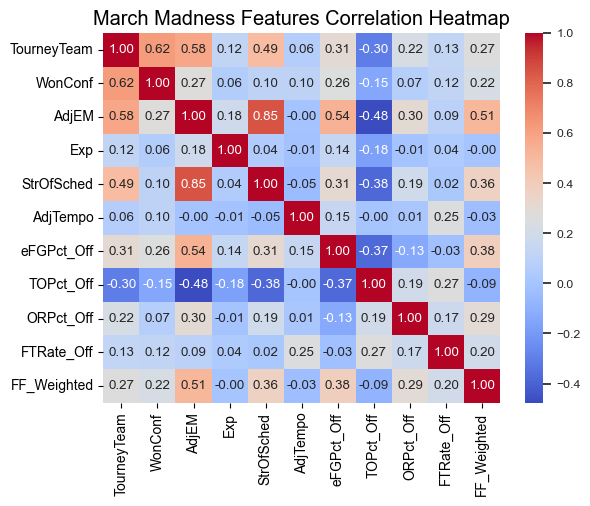

In [7]:
ax = plt.axes()
sns.set(font_scale=0.8)
sns.heatmap((log_df.loc[:, log_df.columns!='TeamName']).corr(), annot = True, cmap = 'coolwarm', ax = ax, fmt='.2f');
# cmap = 'cubehelix',
sns.set(font_scale=1.2)
ax.set_title('March Madness Features Correlation Heatmap')

plt.savefig("heatmap.png")
plt.show()

### Splitting Data for Training and Testing

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 26, stratify = target)

### Fitting Models

In [9]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

model_logistic.score(X_test, y_test)

print(model_logistic.coef_)
print(model_logistic.intercept_)



[[ 0.20383254 -0.0723831   0.15760805  0.09824065  0.02922783 -0.13371683
   0.0512715   0.10574087 -0.13068008]]
[-4.20322855]


In [10]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

print(model_logistic.score(X_test, y_test))

print(model_logistic.coef_)
print(model_logistic.intercept_)

0.94
[[ 0.20383254 -0.0723831   0.15760805  0.09824065  0.02922783 -0.13371683
   0.0512715   0.10574087 -0.13068008]]
[-4.20322855]


In [11]:
len((model_logistic.predict(features)-target)[(model_logistic.predict(features)-target) == 0])/len(target)

0.9516616314199395

### RFE

In [12]:
for n in range(1,9):
    selector = RFE(model_logistic, n_features_to_select=n, step=1)
    selector = selector.fit(features, target)
    print(selector.support_)
    print(selector.ranking_)

[False  True False False False False False False False]
[2 1 7 3 9 8 6 5 4]
[ True  True False False False False False False False]
[1 1 6 2 8 7 5 4 3]
[ True  True False  True False False False False False]
[1 1 5 1 7 6 4 3 2]
[ True  True False  True False False False False  True]
[1 1 4 1 6 5 3 2 1]
[ True  True False  True False False False  True  True]
[1 1 3 1 5 4 2 1 1]
[ True  True False  True False False  True  True  True]
[1 1 2 1 4 3 1 1 1]
[ True  True  True  True False False  True  True  True]
[1 1 1 1 3 2 1 1 1]
[ True  True  True  True False  True  True  True  True]
[1 1 1 1 2 1 1 1 1]


In [31]:
rfe_data = [features[['Exp']], features[['Exp', 'AdjEM']], features[['Exp', 'AdjEM', 'AdjTempo']], features[['Exp', 'AdjEM', 'AdjTempo', 'FF_Weighted']], features[['Exp', 'AdjEM', 'AdjTempo', 'FF_Weighted', 'FTRate_Off']], features[['Exp', 'AdjEM', 'AdjTempo', 'FF_Weighted', 'FTRate_Off', 'ORPct_Off']], features[['Exp', 'AdjEM', 'AdjTempo', 'FF_Weighted', 'FTRate_Off', 'ORPct_Off', 'StrOfSched']], features[['FTRate_Off', 'AdjTempo', 'AdjEM', 'TOPct_Off', 'ORPct_Off', 'eFGPct_Off', 'StrOfSched']], features[['FTRate_Off', 'AdjTempo', 'AdjEM', 'TOPct_Off', 'ORPct_Off', 'eFGPct_Off', 'StrOfSched', 'TOPct_Off', 'eFGPct_Off']]]
for df in rfe_data:
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.3, random_state = 26, stratify = target)
    model_logistic = LogisticRegression()
    model_logistic.fit(X_train, y_train)

    print(model_logistic.score(X_test, y_test))
    print(len((model_logistic.predict(df)-target)[(model_logistic.predict(df)-target) == 0])/len(target))
    print(' ')


0.89
0.8882175226586103
 
0.98
0.9577039274924471
 
0.98
0.9577039274924471
 
0.98
0.9607250755287009
 
0.98
0.9607250755287009
 
0.98
0.9607250755287009
 
0.94
0.9516616314199395
 
0.94
0.9516616314199395
 
0.94
0.9516616314199395
 


### Cross Validation

In [14]:
scores = cross_validate(model_logistic, features, target, scoring='accuracy', cv = 5)
print(scores['test_score'])

[0.97014925 1.         0.92424242 0.92424242 0.95454545]


### Random Forests Classifier

In [15]:
forest = RandomForestClassifier(criterion='gini',
                                 n_estimators=5,
                                 random_state=1 #,
                                 #n_jobs=2
                                 )
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print(forest.feature_importances_)


Accuracy: 0.930
[0.04543977 0.01819256 0.3763101  0.09600356 0.04151652 0.03475765
 0.30277382 0.0564163  0.02858972]


In [16]:
extra = ExtraTreesClassifier(criterion='gini',
                                 n_estimators=5,
                                 random_state=1 #,
                                 #n_jobs=2
                                 )
extra.fit(X_train, y_train)

y_pred = extra.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print(extra.feature_importances_)

Accuracy: 0.930
[0.07598917 0.04871337 0.2378586  0.11161978 0.10575978 0.03555471
 0.24324235 0.0770079  0.06425435]


In [17]:
grad = GradientBoostingClassifier(
                                 n_estimators=5,
                                 random_state=1 #,
                                 #n_jobs=2
                                 )
grad.fit(X_train, y_train)

y_pred = grad.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print(grad.feature_importances_)

Accuracy: 0.930
[0.039681   0.01801444 0.80406252 0.03594938 0.         0.02081406
 0.02166569 0.00867971 0.05113319]


### Final Logistic Regression

In [50]:
final_log = features[['AdjEM', 'StrOfSched', 'Exp', 'AdjTempo', 'FF_Weighted']]

X_train, X_test, y_train, y_test = train_test_split(final_log, target, test_size = 0.3, random_state = 99, stratify = target)

model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

print(model_logistic.score(X_test, y_test))

print(model_logistic.coef_)
print(model_logistic.intercept_)

scores = cross_validate(model_logistic, final_log, target, scoring='accuracy', cv = 5)
print(scores['test_score'])

len((model_logistic.predict(final_log)-target)[(model_logistic.predict(final_log)-target) == 0])/len(target)

# for n in range(1000):
#     X_train, X_test, y_train, y_test = train_test_split(final_log, target, test_size = 0.3, random_state = n, stratify = target)

#     model_logistic = LogisticRegression()
#     model_logistic.fit(X_train, y_train) 

#     for i in model_logistic.coef_:
#         model_logistic = LogisticRegression()
#         model_logistic.fit(X_train, y_train)    
#         for row in model_logistic.coef_:
#             x = 0
#             for coef in row:
#                 x += 1
#                 if x == 5:
#                     if coef >= 0:
#                         print(n)
#                         print(model_logistic.score(X_test, y_test))
# n = 278



0.94
[[ 0.25723081  0.24415686  0.12994094  0.14616954 -0.22773323]]
[-5.86870049]
[0.97014925 1.         0.92424242 0.92424242 0.95454545]


0.9546827794561934

In [54]:
-5.86870049 + (6.32252*0.25723081) + (2.5*0.24415686) + (2.29*0.12994094) + (1.676875*0.14616954) + (-0.205661*-0.22773323)

-3.04245275535627

In [53]:
log_df[log_df['TeamName'] == 'Loyola Marymount']

,TeamName,TourneyTeam,WonConf,AdjEM,Exp,StrOfSched,AdjTempo,eFGPct_Off,TOPct_Off,ORPct_Off,FTRate_Off,FF_Weighted
153,Loyola Marymount,0,0,6.32252,2.29,2.5,1.676875,0.531054,0.18281,0.301276,0.316239,-0.205661


In [19]:
# test_df = log_df[log_df['WonConf'] == 0]
# test_df['Predictions'] = model_logistic.predict(final_log)
# df1 = test_df[test_df['Predictions'] == 0]
# error1 = df1[df1['TourneyTeam'] == 1]
# df2 = test_df[test_df['Predictions'] == 1]
# error2 = df2[df2['TourneyTeam'] == 0]

### Exploratory Analysis

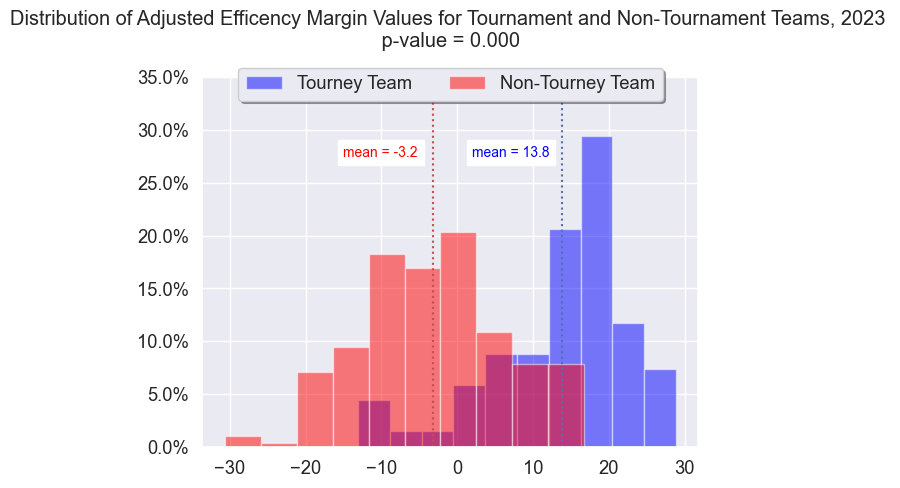

In [75]:
param = 'AdjEM'

Plot_Won_Conf = log_df[log_df['WonConf'] == 1].loc[:, param]
Plot_Tourney_Team = log_df[log_df['TourneyTeam'] == 1].loc[:, param]
Plot_Other = log_df[log_df['TourneyTeam'] == 0].loc[:, param]

cmu_font = {'fontname':'CMU Serif'}

pval = pg.ttest(Plot_Tourney_Team, Plot_Other, correction = True).iloc[:,3]

plt.hist(Plot_Tourney_Team, alpha=0.5, label='Tourney Team', weights=np.ones_like(Plot_Tourney_Team) / len(Plot_Tourney_Team), color = "blue")
plt.hist(Plot_Other, alpha=0.5, label='Non-Tourney Team', weights = np.ones_like(Plot_Other) / len(Plot_Other), color = "red")
plt.ylim([0, 0.35])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)
plt.axvline(x = mean(Plot_Tourney_Team), color = 'b', ls=':')
plt.axvline(x = mean(Plot_Other), color = 'r', ls=':')
plt.text(-15, 0.275, 'mean = %1.1f' % mean(Plot_Other), fontsize = 10, color = 'red',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.text(2, 0.275, 'mean = %1.1f' % mean(Plot_Tourney_Team), fontsize = 10, color = 'blue',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.title("Distribution of Adjusted Efficency Margin Values for Tournament and Non-Tournament Teams, 2023 \n p-value = %1.3f \n" % pval)
plt.show()

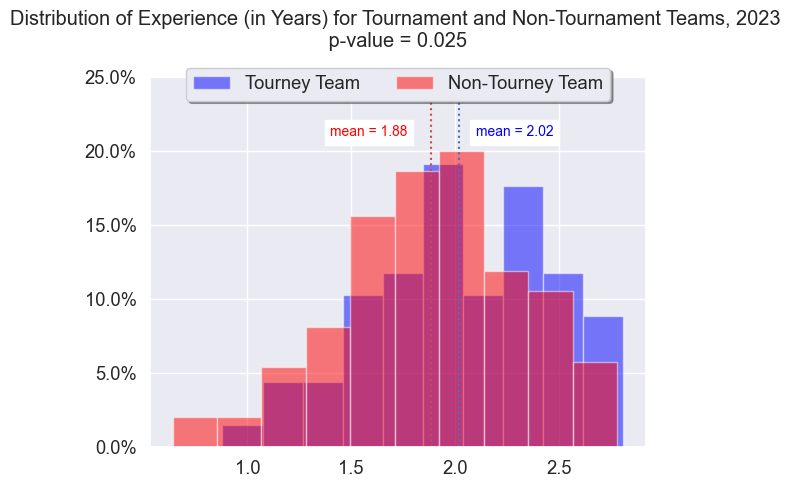

In [65]:
param = 'Exp'

Plot_Won_Conf = log_df[log_df['WonConf'] == 1].loc[:, param]
Plot_Tourney_Team = log_df[log_df['TourneyTeam'] == 1].loc[:, param]
Plot_Other = log_df[log_df['TourneyTeam'] == 0].loc[:, param]

cmu_font = {'fontname':'CMU Serif'}

pval = pg.ttest(Plot_Tourney_Team, Plot_Other, correction = True).iloc[:,3]

plt.hist(Plot_Tourney_Team, alpha=0.5, label='Tourney Team', weights=np.ones_like(Plot_Tourney_Team) / len(Plot_Tourney_Team), color = "blue")
plt.hist(Plot_Other, alpha=0.5, label='Non-Tourney Team', weights = np.ones_like(Plot_Other) / len(Plot_Other), color = "red")
plt.ylim([0, 0.25])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)
plt.axvline(x = mean(Plot_Tourney_Team), color = 'b', ls=':')
plt.axvline(x = mean(Plot_Other), color = 'r', ls=':')
plt.text(1.4, 0.21, 'mean = %1.2f' % mean(Plot_Other), fontsize = 10, color = 'red',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.text(2.1, 0.21, 'mean = %1.2f' % mean(Plot_Tourney_Team), fontsize = 10, color = 'blue',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.title("Distribution of Experience (in Years) for Tournament and Non-Tournament Teams, 2023 \n p-value = %1.3f \n" % pval)
plt.savefig('hist2.png')

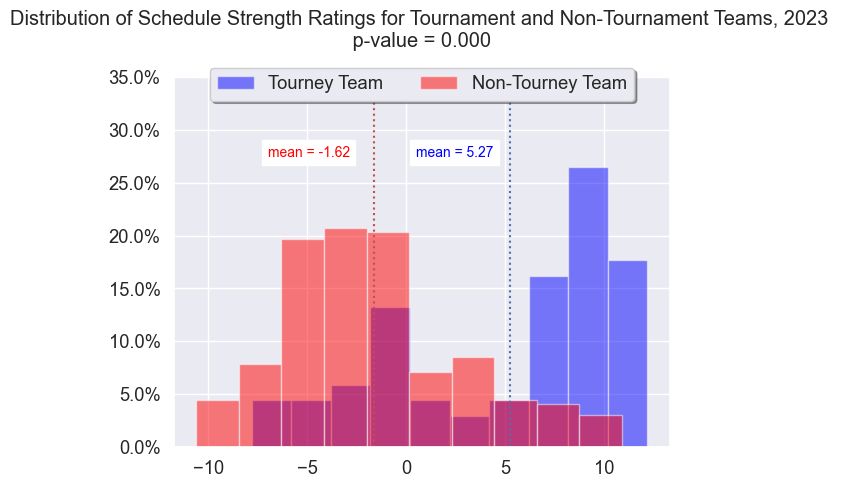

In [66]:
param = 'StrOfSched'

Plot_Won_Conf = log_df[log_df['WonConf'] == 1].loc[:, param]
Plot_Tourney_Team = log_df[log_df['TourneyTeam'] == 1].loc[:, param]
Plot_Other = log_df[log_df['TourneyTeam'] == 0].loc[:, param]

cmu_font = {'fontname':'CMU Serif'}

pval = pg.ttest(Plot_Tourney_Team, Plot_Other, correction = True).iloc[:,3]

plt.hist(Plot_Tourney_Team, alpha=0.5, label='Tourney Team', weights=np.ones_like(Plot_Tourney_Team) / len(Plot_Tourney_Team), color = "blue")
plt.hist(Plot_Other, alpha=0.5, label='Non-Tourney Team', weights = np.ones_like(Plot_Other) / len(Plot_Other), color = "red")
plt.ylim([0, 0.35])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)
plt.axvline(x = mean(Plot_Tourney_Team), color = 'b', ls=':')
plt.axvline(x = mean(Plot_Other), color = 'r', ls=':')
plt.text(-7, 0.275, 'mean = %1.2f' % mean(Plot_Other), fontsize = 10, color = 'red',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.text(0.5, 0.275, 'mean = %1.2f' % mean(Plot_Tourney_Team), fontsize = 10, color = 'blue',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.title("Distribution of Schedule Strength Ratings for Tournament and Non-Tournament Teams, 2023 \n p-value = %1.3f \n" % pval)
plt.savefig('hist3.png')

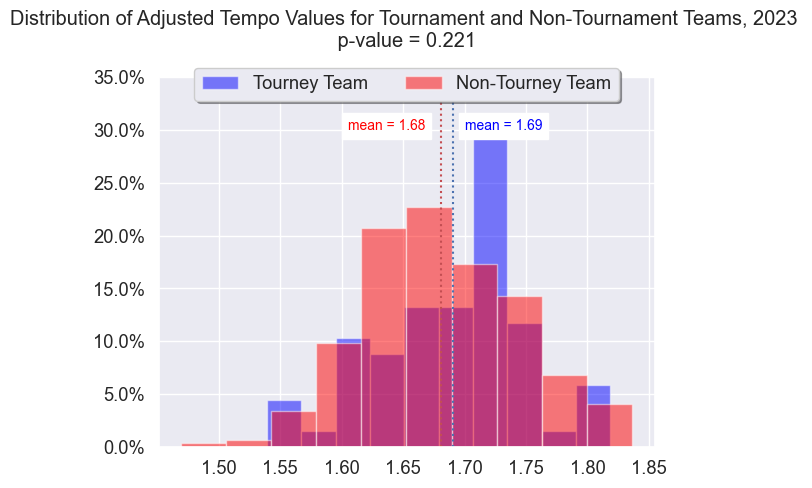

In [67]:
param = 'AdjTempo'

Plot_Won_Conf = log_df[log_df['WonConf'] == 1].loc[:, param]
Plot_Tourney_Team = log_df[log_df['TourneyTeam'] == 1].loc[:, param]
Plot_Other = log_df[log_df['TourneyTeam'] == 0].loc[:, param]

cmu_font = {'fontname':'CMU Serif'}

pval = pg.ttest(Plot_Tourney_Team, Plot_Other, correction = True).iloc[:,3]

plt.hist(Plot_Tourney_Team, alpha=0.5, label='Tourney Team', weights=np.ones_like(Plot_Tourney_Team) / len(Plot_Tourney_Team), color = "blue")
plt.hist(Plot_Other, alpha=0.5, label='Non-Tourney Team', weights = np.ones_like(Plot_Other) / len(Plot_Other), color = "red")
plt.ylim([0, 0.35])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)
plt.axvline(x = mean(Plot_Tourney_Team), color = 'b', ls=':')
plt.axvline(x = mean(Plot_Other), color = 'r', ls=':')
plt.text(1.605, 0.3, 'mean = %1.2f' % mean(Plot_Other), fontsize = 10, color = 'red',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.text(1.7, 0.3, 'mean = %1.2f' % mean(Plot_Tourney_Team), fontsize = 10, color = 'blue',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.title("Distribution of Adjusted Tempo Values for Tournament and Non-Tournament Teams, 2023 \n p-value = %1.3f \n" % pval)
plt.savefig('hist4.png')

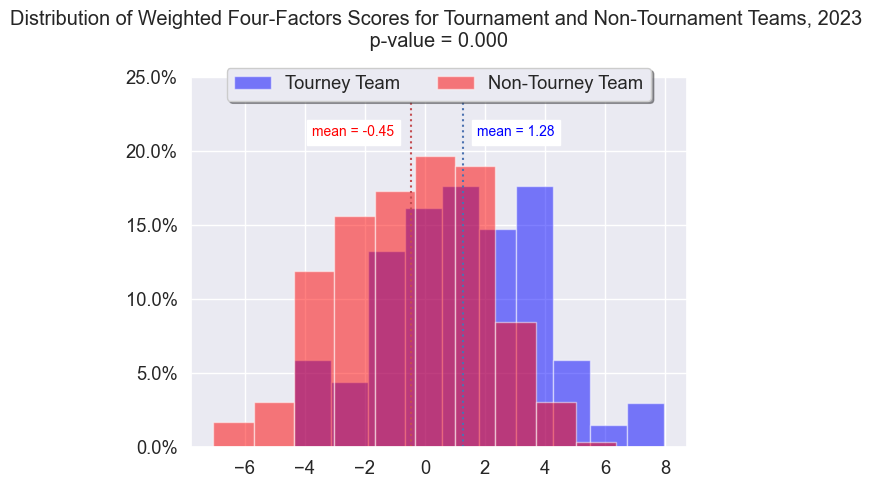

In [68]:
param = 'FF_Weighted'

Plot_Won_Conf = log_df[log_df['WonConf'] == 1].loc[:, param]
Plot_Tourney_Team = log_df[log_df['TourneyTeam'] == 1].loc[:, param]
Plot_Other = log_df[log_df['TourneyTeam'] == 0].loc[:, param]

cmu_font = {'fontname':'CMU Serif'}

pval = pg.ttest(Plot_Tourney_Team, Plot_Other, correction = True).iloc[:,3]

plt.hist(Plot_Tourney_Team, alpha=0.5, label='Tourney Team', weights=np.ones_like(Plot_Tourney_Team) / len(Plot_Tourney_Team), color = "blue")
plt.hist(Plot_Other, alpha=0.5, label='Non-Tourney Team', weights = np.ones_like(Plot_Other) / len(Plot_Other), color = "red")
plt.ylim([0, 0.25])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)
plt.axvline(x = mean(Plot_Tourney_Team), color = 'b', ls=':')
plt.axvline(x = mean(Plot_Other), color = 'r', ls=':')
plt.text(-3.75, 0.21, 'mean = %1.2f' % mean(Plot_Other), fontsize = 10, color = 'red',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.text(1.75, 0.21, 'mean = %1.2f' % mean(Plot_Tourney_Team), fontsize = 10, color = 'blue',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.title("Distribution of Weighted Four-Factors Scores for Tournament and Non-Tournament Teams, 2023 \n p-value = %1.3f \n" % pval)
plt.savefig('hist5.png')

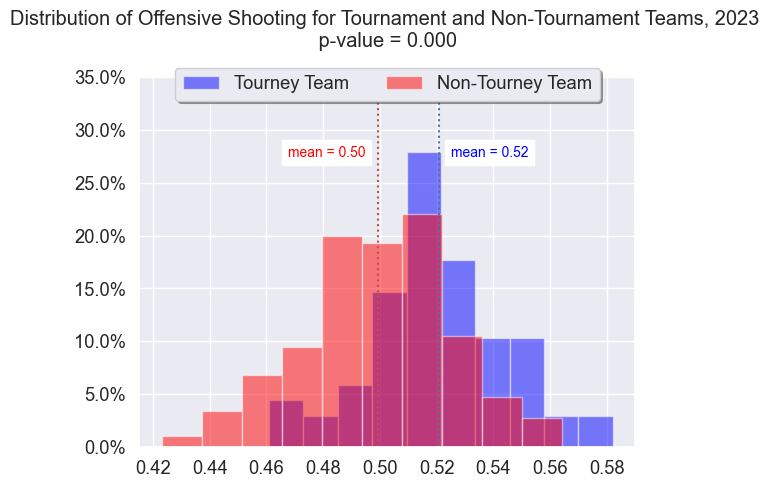

In [69]:
param = 'eFGPct_Off'

Plot_Won_Conf = log_df[log_df['WonConf'] == 1].loc[:, param]
Plot_Tourney_Team = log_df[log_df['TourneyTeam'] == 1].loc[:, param]
Plot_Other = log_df[log_df['TourneyTeam'] == 0].loc[:, param]

cmu_font = {'fontname':'CMU Serif'}

pval = pg.ttest(Plot_Tourney_Team, Plot_Other, correction = True).iloc[:,3]

plt.hist(Plot_Tourney_Team, alpha=0.5, label='Tourney Team', weights=np.ones_like(Plot_Tourney_Team) / len(Plot_Tourney_Team), color = "blue")
plt.hist(Plot_Other, alpha=0.5, label='Non-Tourney Team', weights = np.ones_like(Plot_Other) / len(Plot_Other), color = "red")
plt.ylim([0, 0.35])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)
plt.axvline(x = mean(Plot_Tourney_Team), color = 'b', ls=':')
plt.axvline(x = mean(Plot_Other), color = 'r', ls=':')
plt.text(0.4675, 0.275, 'mean = %1.2f' % mean(Plot_Other), fontsize = 10, color = 'red',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.text(0.525, 0.275, 'mean = %1.2f' % mean(Plot_Tourney_Team), fontsize = 10, color = 'blue',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.title("Distribution of Offensive Shooting for Tournament and Non-Tournament Teams, 2023 \n p-value = %1.3f \n" % pval)
plt.savefig('hist6.png')

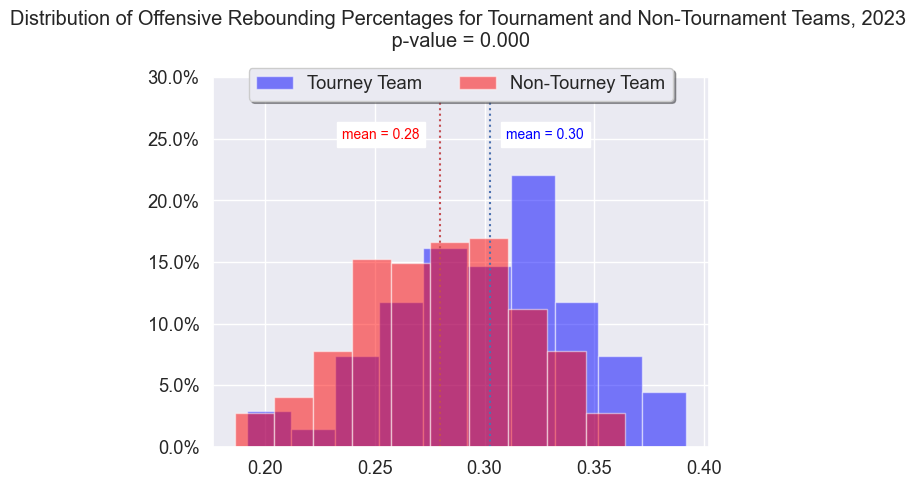

In [70]:
param = 'ORPct_Off'

Plot_Won_Conf = log_df[log_df['WonConf'] == 1].loc[:, param]
Plot_Tourney_Team = log_df[log_df['TourneyTeam'] == 1].loc[:, param]
Plot_Other = log_df[log_df['TourneyTeam'] == 0].loc[:, param]

cmu_font = {'fontname':'CMU Serif'}

pval = pg.ttest(Plot_Tourney_Team, Plot_Other, correction = True).iloc[:,3]

plt.hist(Plot_Tourney_Team, alpha=0.5, label='Tourney Team', weights=np.ones_like(Plot_Tourney_Team) / len(Plot_Tourney_Team), color = "blue")
plt.hist(Plot_Other, alpha=0.5, label='Non-Tourney Team', weights = np.ones_like(Plot_Other) / len(Plot_Other), color = "red")
plt.ylim([0, 0.3])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)
plt.axvline(x = mean(Plot_Tourney_Team), color = 'b', ls=':')
plt.axvline(x = mean(Plot_Other), color = 'r', ls=':')
plt.text(0.235, 0.25, 'mean = %1.2f' % mean(Plot_Other), fontsize = 10, color = 'red',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.text(0.31, 0.25, 'mean = %1.2f' % mean(Plot_Tourney_Team), fontsize = 10, color = 'blue',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.title("Distribution of Offensive Rebounding Percentages for Tournament and Non-Tournament Teams, 2023 \n p-value = %1.3f \n" % pval)
plt.savefig('hist7.png')

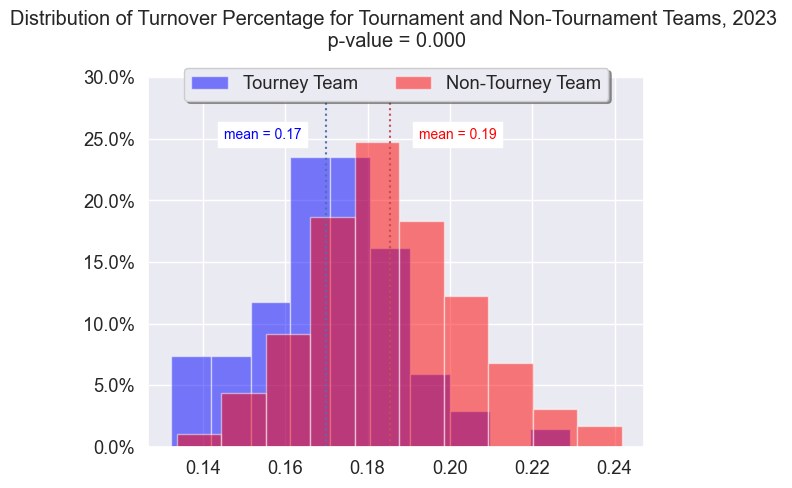

In [71]:
param = 'TOPct_Off'

Plot_Won_Conf = log_df[log_df['WonConf'] == 1].loc[:, param]
Plot_Tourney_Team = log_df[log_df['TourneyTeam'] == 1].loc[:, param]
Plot_Other = log_df[log_df['TourneyTeam'] == 0].loc[:, param]

cmu_font = {'fontname':'CMU Serif'}

pval = pg.ttest(Plot_Tourney_Team, Plot_Other, correction = True).iloc[:,3]

plt.hist(Plot_Tourney_Team, alpha=0.5, label='Tourney Team', weights=np.ones_like(Plot_Tourney_Team) / len(Plot_Tourney_Team), color = "blue")
plt.hist(Plot_Other, alpha=0.5, label='Non-Tourney Team', weights = np.ones_like(Plot_Other) / len(Plot_Other), color = "red")
plt.ylim([0, 0.3])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)
plt.axvline(x = mean(Plot_Tourney_Team), color = 'b', ls=':')
plt.axvline(x = mean(Plot_Other), color = 'r', ls=':')
plt.text(0.1925, 0.25, 'mean = %1.2f' % mean(Plot_Other), fontsize = 10, color = 'red',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.text(0.145, 0.25, 'mean = %1.2f' % mean(Plot_Tourney_Team), fontsize = 10, color = 'blue',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.title("Distribution of Turnover Percentage for Tournament and Non-Tournament Teams, 2023 \n p-value = %1.3f \n" % pval)
plt.savefig('hist8.png')

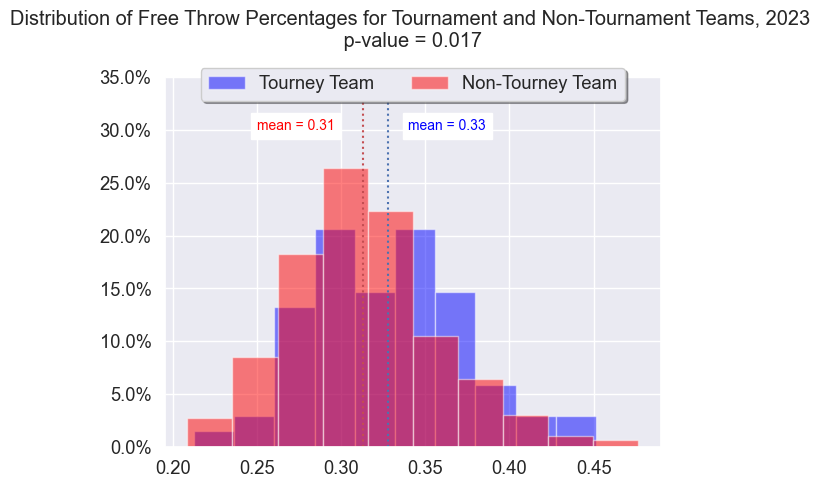

In [72]:
param = 'FTRate_Off'

Plot_Won_Conf = log_df[log_df['WonConf'] == 1].loc[:, param]
Plot_Tourney_Team = log_df[log_df['TourneyTeam'] == 1].loc[:, param]
Plot_Other = log_df[log_df['TourneyTeam'] == 0].loc[:, param]

cmu_font = {'fontname':'CMU Serif'}

pval = pg.ttest(Plot_Tourney_Team, Plot_Other, correction = True).iloc[:,3]

plt.hist(Plot_Tourney_Team, alpha=0.5, label='Tourney Team', weights=np.ones_like(Plot_Tourney_Team) / len(Plot_Tourney_Team), color = "blue")
plt.hist(Plot_Other, alpha=0.5, label='Non-Tourney Team', weights = np.ones_like(Plot_Other) / len(Plot_Other), color = "red")
plt.ylim([0, 0.35])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)
plt.axvline(x = mean(Plot_Tourney_Team), color = 'b', ls=':')
plt.axvline(x = mean(Plot_Other), color = 'r', ls=':')
plt.text(0.25, 0.3, 'mean = %1.2f' % mean(Plot_Other), fontsize = 10, color = 'red',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.text(0.34, 0.3, 'mean = %1.2f' % mean(Plot_Tourney_Team), fontsize = 10, color = 'blue',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.title("Distribution of Free Throw Percentages for Tournament and Non-Tournament Teams, 2023 \n p-value = %1.3f \n" % pval)
plt.savefig('hist9.png')

In [ ]:
param = 'TOPct_Def'

Plot_Won_Conf = df[df['WonConf'] == 1].loc[:, param]
Plot_Tourney_Team = df[df['TourneyTeam'] == 1].loc[:, param]
Plot_Other = df[df['TourneyTeam'] == 0].loc[:, param]

cmu_font = {'fontname':'CMU Serif'}

pval = pg.ttest(Plot_Tourney_Team, Plot_Other, correction = True).iloc[:,3]

plt.hist(Plot_Tourney_Team, alpha=0.5, label='Tourney Team', weights=np.ones_like(Plot_Tourney_Team) / len(Plot_Tourney_Team), color = "blue")
plt.hist(Plot_Other, alpha=0.5, label='Non-Tourney Team', weights = np.ones_like(Plot_Other) / len(Plot_Other), color = "red")
plt.ylim([0, 0.35])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=2, fancybox=True, shadow=True)
plt.axvline(x = mean(Plot_Tourney_Team), color = 'b', ls=':')
plt.axvline(x = mean(Plot_Other), color = 'r', ls=':')
plt.text(15, 0.305, 'mean = %1.2f' % mean(Plot_Other), fontsize = 10, color = 'red',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.text(19.5, 0.305, 'mean = %1.2f' % mean(Plot_Tourney_Team), fontsize = 10, color = 'blue',
         bbox = dict(facecolor = 'white', alpha = 1))
plt.title("Distribution of Turnover Percentage (Defensive) for Tournament and Non-Tournament Teams, 2023 \n p-value = %1.3f \n" % pval)
plt.show()